In [5]:
!nvitop

)07=Sat May 10 18:51:09 2025
‚ïí‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïï
‚îÇ NVITOP 1.5.0      Driver Version: 535.183.01      CUDA Driver Version: 12.2 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ GPU  Name        Persistence-M‚îÇ Bus-Id        Disp.A ‚îÇ Volatile Uncorr. ECC ‚îÇ
‚îÇ Fan  Temp  Perf  Pwr:Usage/Cap‚îÇ         Memory-Usage ‚îÇ GPU-Util  Compute M. ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚

In [52]:
# CUDA_VISIBLE_DEVICES=5
import sys
sys.path.append("/c2/jinakim/Drug_Discovery_j")

import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from main_merck_all_real import Merck

def plot_cos_sim(vec_type, cos_sim_type):
    dataset_names = [
        "3a4", "logd", "hivint", "metab", "ox2", "rat_f", "cb1", "hivprot", "nk1",
        "pgp", "tdi", "dpp4", "ox1", "ppb", "thrombin"
    ]

    vectors = []
    for name in dataset_names:
        dataset = Merck(
            split="train", vec_type=vec_type,
            dataset=name, is_context=False,
            mvalid_dataset=[], exclude_mval_data_in_context=False
        )

        if cos_sim_type == 'data':
            vec = torch.stack([dataset[i][0] for i in range(len(dataset))], dim=0)  # (N, feature_dim)
        else:
            raise ValueError("cos_sim_type must be 'data'")

        vectors.append(vec)

    cos_sim_matrix = np.zeros((len(dataset_names), len(dataset_names)))

    for i in range(len(dataset_names)):
        for j in range(len(dataset_names)):
            # print(f"Computing similarity {i}, {j}")
            x = vectors[i].cuda(5)
            y = vectors[j].cuda(5)

            x = torch.nn.functional.normalize(x, dim=-1)
            y = torch.nn.functional.normalize(y, dim=-1)

            sim = (x @ y.T).mean().item()

            cos_sim_matrix[i, j] = sim

    cos_sim_df = pd.DataFrame(cos_sim_matrix, index=dataset_names, columns=dataset_names)

    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(cos_sim_df, cmap="rocket_r", square=True, vmin=0, vmax=1, annot=False)
    plt.title(f"Cosine Similarity Between Merck Datasets (vector={vec_type})")
    plt.tight_layout()

    # Save both PNG and PDF
    save_dir = "/c2/jinakim/Drug_Discovery_j/analysis/cosine_similarity_results"
    os.makedirs(save_dir, exist_ok=True)

    png_path = os.path.join(save_dir, f"cos_sim_{vec_type}_{cos_sim_type}.png")
    pdf_path = os.path.join(save_dir, f"cos_sim_{vec_type}_{cos_sim_type}.pdf")

    plt.savefig(png_path)
    plt.savefig(pdf_path)
    print(f"‚úÖ Saved heatmap to:\n{png_path}\n{pdf_path}")

    plt.show()

    return cos_sim_df

# Example usage:
# cos_sim_df_count_data = plot_cos_sim("count", "data")
# cos_sim_df_bit_data = plot_cos_sim("bit", "data")


=====
MERCK_REAL exclude False
is_context  False
mvalid_dataset  []
files  ['3A4_train.pt']
=====
MERCK_REAL exclude False
is_context  False
mvalid_dataset  []
files  ['LOGD_train.pt']
=====
MERCK_REAL exclude False
is_context  False
mvalid_dataset  []
files  ['HIVINT_train.pt']
=====
MERCK_REAL exclude False
is_context  False
mvalid_dataset  []
files  ['METAB_train.pt']
=====
MERCK_REAL exclude False
is_context  False
mvalid_dataset  []
files  ['OX2_train.pt']
=====
MERCK_REAL exclude False
is_context  False
mvalid_dataset  []
files  ['RAT_F_train.pt']
=====
MERCK_REAL exclude False
is_context  False
mvalid_dataset  []
files  ['CB1_train.pt']
=====
MERCK_REAL exclude False
is_context  False
mvalid_dataset  []
files  ['HIVPROT_train.pt']
=====
MERCK_REAL exclude False
is_context  False
mvalid_dataset  []
files  ['NK1_train.pt']
=====
MERCK_REAL exclude False
is_context  False
mvalid_dataset  []
files  ['PGP_train.pt']
=====
MERCK_REAL exclude False
is_context  False
mvalid_dataset  []


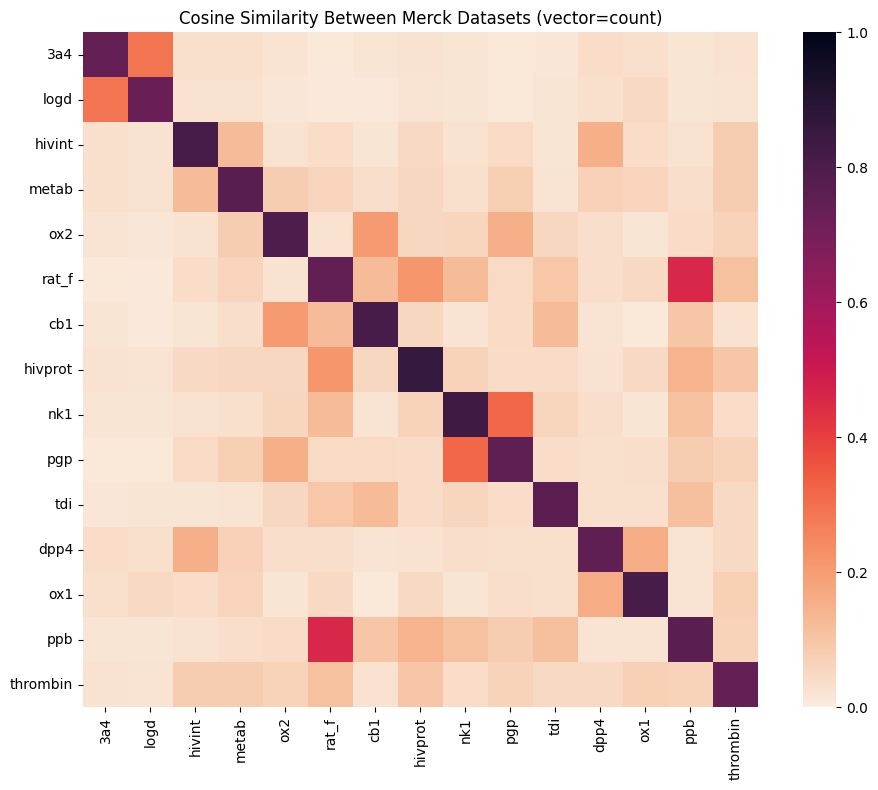

In [53]:
cos_sim_df_count_data = plot_cos_sim("count", "data")

=====
MERCK_REAL exclude False
is_context  False
mvalid_dataset  []
files  ['3A4_train.pt']
=====
MERCK_REAL exclude False
is_context  False
mvalid_dataset  []
files  ['LOGD_train.pt']
=====
MERCK_REAL exclude False
is_context  False
mvalid_dataset  []
files  ['HIVINT_train.pt']
=====
MERCK_REAL exclude False
is_context  False
mvalid_dataset  []
files  ['METAB_train.pt']
=====
MERCK_REAL exclude False
is_context  False
mvalid_dataset  []
files  ['OX2_train.pt']
=====
MERCK_REAL exclude False
is_context  False
mvalid_dataset  []
files  ['RAT_F_train.pt']
=====
MERCK_REAL exclude False
is_context  False
mvalid_dataset  []
files  ['CB1_train.pt']
=====
MERCK_REAL exclude False
is_context  False
mvalid_dataset  []
files  ['HIVPROT_train.pt']
=====
MERCK_REAL exclude False
is_context  False
mvalid_dataset  []
files  ['NK1_train.pt']
=====
MERCK_REAL exclude False
is_context  False
mvalid_dataset  []
files  ['PGP_train.pt']
=====
MERCK_REAL exclude False
is_context  False
mvalid_dataset  []


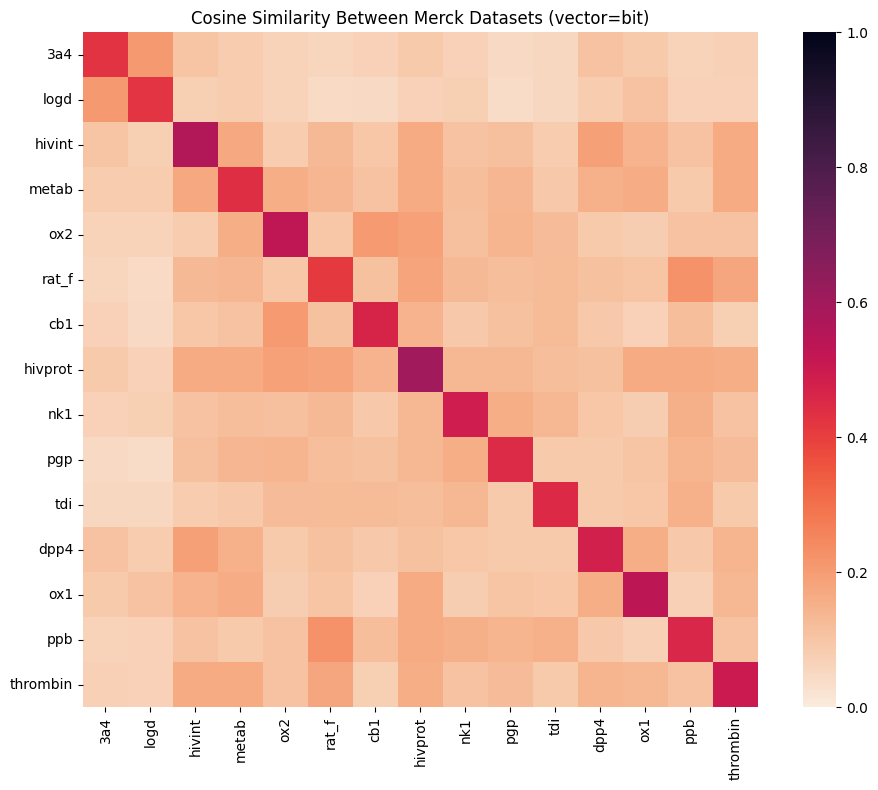

In [54]:
cos_sim_df_bit_data = plot_cos_sim("bit", "data")

In [14]:
# Flatten the similarity matrix, exclude self-similarity (diagonal)
def print_most_high_small_sim_pair(cos_sim_df):
    sorted_similarities = (
        cos_sim_df.where(~np.eye(cos_sim_df.shape[0], dtype=bool))  # mask diagonal
        .stack()  # flatten to Series (multi-index)
        .reset_index()
    )

    # Rename columns for clarity
    sorted_similarities.columns = ['Dataset1', 'Dataset2', 'CosineSimilarity']

    # Sort descending (higher to lower similarity)
    sorted_high_to_low = sorted_similarities.sort_values(by='CosineSimilarity', ascending=False)

    # Sort ascending (lower to higher similarity)
    sorted_low_to_high = sorted_similarities.sort_values(by='CosineSimilarity', ascending=True)

    # Display top 10 most similar and least similar pairs
    print("üîù Top 10 Most Similar Dataset Pairs:")
    print(sorted_high_to_low.head(10))

    print("\nüîª Top 10 Least Similar Dataset Pairs:")
    print(sorted_low_to_high.head(10))


In [15]:
# Reuse the same sorted similarity list from before

def print_middle_sim_pair(cos_sim_df):
    sorted_similarities = (
        cos_sim_df.where(~np.eye(cos_sim_df.shape[0], dtype=bool))  # mask diagonal
        .stack()
        .reset_index()
    )
    sorted_similarities.columns = ['Dataset1', 'Dataset2', 'CosineSimilarity']

    # Sort full list
    sorted_similarities = sorted_similarities.sort_values(by='CosineSimilarity', ascending=True).reset_index(drop=True)

    # Total number of unique non-diagonal pairs
    n = len(sorted_similarities)

    # Define how many middle pairs to extract (e.g., 10)
    k = 10
    middle_start = n // 2 - k // 2
    middle_end = middle_start + k

    # Extract middle k pairs
    middle_pairs = sorted_similarities.iloc[middle_start:middle_end]

    print("üîò Middle Similarity Dataset Pairs:")
    print(middle_pairs)

    # ['metab', 'ox2']
    # logd    rat_f
    # ppb      3a4

In [98]:
def print_most_high_small_sim_avg_dataset(cos_sim_df):
    # Copy the cosine similarity DataFrame to avoid modifying the original
    cos_sim_no_diag = cos_sim_df.copy()

    # Set diagonal (self-similarity) to NaN
    np.fill_diagonal(cos_sim_no_diag.values, np.nan)

    # Compute average similarity to other datasets (skip NaNs)
    average_similarities = cos_sim_no_diag.mean(axis=1)

    # Sort from highest to lowest average similarity
    sorted_avg_high_to_low = average_similarities.sort_values(ascending=False)

    # Sort from lowest to highest
    sorted_avg_low_to_high = average_similarities.sort_values(ascending=True)

    # print("üîù Datasets with Highest Average Cosine Similarity to Others:")
    # print(sorted_avg_high_to_low)

    print("\nüîª Datasets with Lowest Average Cosine Similarity to Others:")
    print(sorted_avg_low_to_high)


In [17]:
from collections import OrderedDict

# List of Merck datasets (task names)
dataset_names = [
    "3a4", "logd", "hivint", "metab", "ox2", "rat_f", "cb1", "hivprot", "nk1",
    "pgp", "tdi", "dpp4", "ox1", "ppb", "thrombin"
]

# Compute dataset sizes
dataset_sizes = {
    name: len(Merck(split="train", vec_type="count", dataset=name,
                    is_context=False, mvalid_dataset=[], exclude_mval_data_in_context=False))
    for name in dataset_names
}

# Sort from largest to smallest
sorted_sizes_desc = OrderedDict(sorted(dataset_sizes.items(), key=lambda x: x[1], reverse=True))

# Sort from smallest to largest
sorted_sizes_asc = OrderedDict(sorted(dataset_sizes.items(), key=lambda x: x[1]))

# Print both
print("üìä Dataset sizes (largest to smallest):")
for name, size in sorted_sizes_desc.items():
    print(f"{name}: {size}")

print("\nüìâ Dataset sizes (smallest to largest):")
for name, size in sorted_sizes_asc.items():
    print(f"{name}: {size}")


=====
MERCK_REAL exclude False
is_context  False
mvalid_dataset  []
files  ['3A4_train.pt']
=====
MERCK_REAL exclude False
is_context  False
mvalid_dataset  []
files  ['LOGD_train.pt']
=====
MERCK_REAL exclude False
is_context  False
mvalid_dataset  []
files  ['HIVINT_train.pt']
=====
MERCK_REAL exclude False
is_context  False
mvalid_dataset  []
files  ['METAB_train.pt']
=====
MERCK_REAL exclude False
is_context  False
mvalid_dataset  []
files  ['OX2_train.pt']
=====
MERCK_REAL exclude False
is_context  False
mvalid_dataset  []
files  ['RAT_F_train.pt']
=====
MERCK_REAL exclude False
is_context  False
mvalid_dataset  []
files  ['CB1_train.pt']
=====
MERCK_REAL exclude False
is_context  False
mvalid_dataset  []
files  ['HIVPROT_train.pt']
=====
MERCK_REAL exclude False
is_context  False
mvalid_dataset  []
files  ['NK1_train.pt']
=====
MERCK_REAL exclude False
is_context  False
mvalid_dataset  []
files  ['PGP_train.pt']
=====
MERCK_REAL exclude False
is_context  False
mvalid_dataset  []


### Counter

### dataset size (large to small)

logd: 37388

3a4: 37241

ox2: 11151

nk1: 9965

cb1: 8716

ppb: 8651

pgp: 6399

dpp4: 6148

rat_f: 6105

ox1: 5351

thrombin: 5059

tdi: 4165

hivprot: 3212

hivint: 1815

metab: 1569


In [77]:
print_most_high_small_sim_pair(cos_sim_df_count_data)

üîù Top 10 Most Similar Dataset Pairs:
    Dataset1 Dataset2  CosineSimilarity
187      ppb    rat_f          0.457898
82     rat_f      ppb          0.457898
120      nk1      pgp          0.319777
134      pgp      nk1          0.319777
0        3a4     logd          0.291844
14      logd      3a4          0.291844
103  hivprot    rat_f          0.218584
76     rat_f  hivprot          0.218584
88       cb1      ox2          0.206292
61       ox2      cb1          0.206292

üîª Top 10 Least Similar Dataset Pairs:
    Dataset1 Dataset2  CosineSimilarity
18      logd    rat_f          0.007610
71     rat_f     logd          0.007610
85       cb1     logd          0.007759
19      logd      cb1          0.007759
22      logd      pgp          0.008142
127      pgp     logd          0.008142
95       cb1      ox1          0.010840
174      ox1      cb1          0.010840
70     rat_f      3a4          0.011089
4        3a4    rat_f          0.011089


In [99]:
print_most_high_small_sim_avg_dataset(cos_sim_df_count_data)


üîª Datasets with Lowest Average Cosine Similarity to Others:
logd        0.039094
3a4         0.041414
ox1         0.045407
tdi         0.049581
hivint      0.049632
dpp4        0.052226
metab       0.055313
cb1         0.057175
thrombin    0.060052
ox2         0.060711
nk1         0.066884
hivprot     0.067021
pgp         0.070599
ppb         0.089596
rat_f       0.100153
dtype: float64


In [95]:
import numpy as np
import pandas as pd

def rank_by_similarity_variance(data, cos_sim_df):
    # Copy and set diagonal (self-similarity) to NaN
    cos_sim_no_diag = cos_sim_df.copy()
    np.fill_diagonal(cos_sim_no_diag.values, np.nan)
    
    if data == "hivprot":
        columns_to_exclude = ["dpp4", "nk1"]
    elif data == "dpp4":
        columns_to_exclude = ["hivprot", "nk1"]
    elif data == "nk1":
        columns_to_exclude = ["hivprot", "dpp4"]
    cos_sim_excluded = cos_sim_no_diag.drop(columns=columns_to_exclude, index=columns_to_exclude)


    # Compute variance per dataset (skip NaN)
    variances = cos_sim_excluded.var(axis=1, skipna=True)

    # Sort by variance ascending (lower variance first)
    ranked = variances.sort_values(ascending=True)

    return ranked




In [96]:
# Example usage:
ranked_by_var = rank_by_similarity_variance("hivprot", cos_sim_df_count_data)
print(ranked_by_var)

ox1         0.000348
thrombin    0.000824
hivint      0.000950
metab       0.000952
pgp         0.001519
tdi         0.001548
hivprot     0.003320
ox2         0.003547
cb1         0.003819
3a4         0.006151
logd        0.006322
ppb         0.014956
rat_f       0.015956
dtype: float64


In [97]:
# Example usage:
ranked_by_var = rank_by_similarity_variance("hivprot", cos_sim_df_bit_data)
print(ranked_by_var)

tdi         0.000898
ox1         0.001143
pgp         0.001197
hivint      0.001211
metab       0.001317
hivprot     0.001352
thrombin    0.001525
cb1         0.001774
3a4         0.001812
logd        0.002042
ppb         0.002168
ox2         0.002210
rat_f       0.002657
dtype: float64


In [87]:
def print_most_high_small_sim_avg_dataset_exclude(data, cos_sim_df):
    # Copy the cosine similarity DataFrame to avoid modifying the original
    cos_sim_no_diag = cos_sim_df.copy()

    # Set diagonal (self-similarity) to NaN
    np.fill_diagonal(cos_sim_no_diag.values, np.nan)

    # Exclude similarity with 'dpp4' and 'nk1' when computing averages
    if data == "hivprot":
        columns_to_exclude = ["dpp4", "nk1"]
    elif data == "dpp4":
        columns_to_exclude = ["hivprot", "nk1"]
    elif data == "nk1":
        columns_to_exclude = ["hivprot", "dpp4"]
    cos_sim_excluded = cos_sim_no_diag.drop(columns=columns_to_exclude, index=columns_to_exclude)

    # Now compute the average similarity to remaining datasets
    average_similarities = cos_sim_excluded.mean(axis=1)

    # Sort from highest to lowest
    sorted_avg_high_to_low = average_similarities.sort_values(ascending=False)

    # Sort from lowest to highest
    sorted_avg_low_to_high = average_similarities.sort_values(ascending=True)

    # Print results
    print("\nüîª Datasets with Lowest Average Cosine Similarity to Others (excluding dpp4, nk1):")
    print(sorted_avg_low_to_high)

    # print("\nüîù Datasets with Highest Average Cosine Similarity to Others (excluding dpp4, nk1):")
    # print(sorted_avg_high_to_low)

    # return sorted_avg_low_to_high, sorted_avg_high_to_low


In [88]:
print_most_high_small_sim_avg_dataset_exclude("hivprot", cos_sim_df_count_data)


üîª Datasets with Lowest Average Cosine Similarity to Others (excluding dpp4, nk1):
ox1         0.037951
logd        0.041783
hivint      0.042901
3a4         0.043750
tdi         0.050836
pgp         0.053240
metab       0.056230
thrombin    0.062855
ox2         0.063206
cb1         0.063241
hivprot     0.070505
ppb         0.093625
rat_f       0.103323
dtype: float64


In [91]:
print_most_high_small_sim_avg_dataset_exclude("hivprot", cos_sim_df_bit_data)



üîª Datasets with Lowest Average Cosine Similarity to Others (excluding dpp4, nk1):
logd        0.077356
3a4         0.083271
tdi         0.100056
cb1         0.107653
pgp         0.109188
ox1         0.110271
ox2         0.118284
ppb         0.118751
hivint      0.120439
thrombin    0.120894
rat_f       0.125866
metab       0.129643
hivprot     0.146551
dtype: float64


In [89]:
print_most_high_small_sim_avg_dataset_exclude("dpp4", cos_sim_df_count_data)



üîª Datasets with Lowest Average Cosine Similarity to Others (excluding dpp4, nk1):
logd        0.042469
3a4         0.044763
ox1         0.047404
tdi         0.049847
hivint      0.051673
pgp         0.052291
dpp4        0.055808
metab       0.057735
thrombin    0.058764
cb1         0.060444
ox2         0.061601
ppb         0.083243
rat_f       0.088009
dtype: float64


In [92]:
print_most_high_small_sim_avg_dataset_exclude("dpp4", cos_sim_df_bit_data)



üîª Datasets with Lowest Average Cosine Similarity to Others (excluding dpp4, nk1):
logd        0.078573
3a4         0.084764
tdi         0.097378
cb1         0.103227
pgp         0.105271
ox1         0.109733
ox2         0.110028
ppb         0.112541
dpp4        0.117045
thrombin    0.119564
rat_f       0.119999
hivint      0.122792
metab       0.128296
dtype: float64


In [90]:
print_most_high_small_sim_avg_dataset_exclude("nk1", cos_sim_df_count_data)



üîª Datasets with Lowest Average Cosine Similarity to Others (excluding dpp4, nk1):
ox1         0.035282
hivint      0.040758
logd        0.041572
3a4         0.043064
tdi         0.052265
metab       0.054483
thrombin    0.057869
cb1         0.060428
ox2         0.063657
nk1         0.069767
pgp         0.076461
ppb         0.090635
rat_f       0.095728
dtype: float64


In [93]:
print_most_high_small_sim_avg_dataset_exclude("nk1", cos_sim_df_bit_data)



üîª Datasets with Lowest Average Cosine Similarity to Others (excluding dpp4, nk1):
logd        0.077948
3a4         0.081366
tdi         0.101121
cb1         0.103107
ox1         0.103260
pgp         0.110945
nk1         0.111316
ox2         0.112164
hivint      0.115342
thrombin    0.116598
ppb         0.117544
rat_f       0.121315
metab       0.125728
dtype: float64


In [22]:
def rank_similarity_scores(cos_sim_df, dataset_name):
    ranked = cos_sim_df.loc[dataset_name].sort_values(ascending=False)
    return ranked



### hivprot count

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

def rank_similarity_scores(cos_sim_df, dataset_name):
    ranked = cos_sim_df.loc[dataset_name].sort_values(ascending=False)
    return ranked

def visualize_ranked_similarity(ranked_similarity, dataset_name, save_dir="./cosine_similarity_results", vec="count"):
    # Convert to DataFrame
    df = ranked_similarity.reset_index()
    df.columns = ['Dataset', 'Similarity']

    # Sort again (optional ‚Äî already sorted by rank_similarity_scores)
    df = df.sort_values('Similarity', ascending=True)

    # Plot
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Similarity', y='Dataset', data=df, palette='rocket')

    # Annotate each bar
    for index, value in enumerate(df['Similarity']):
        plt.text(value + 0.005, index, f"{value:.3f}", va='center', fontsize=8)

    plt.title(f'Similarity to {dataset_name.upper()} across datasets (vector={vec})')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Dataset')
    plt.xlim(0, 1)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Save
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(os.path.join(save_dir, f"{dataset_name}_{vec}similarity_barplot.png"))
    plt.savefig(os.path.join(save_dir, f"{dataset_name}_{vec}_similarity_barplot.pdf"))
    plt.show()

# Example Usage:
# Assume you already have cos_sim_df (15x15 matrix)



In [107]:
def rank_similarity_scores_exclude(cos_sim_df, dataset_name):
    # Compute similarity scores for the given dataset
    ranked = cos_sim_df.loc[dataset_name].copy()

    # Exclude 'hivprot', 'nk1', 'dpp4'
    to_exclude = ['hivprot', 'nk1', 'dpp4']
    ranked = ranked.drop(to_exclude, errors='ignore')

    # Sort from lowest to highest similarity
    ranked = ranked.sort_values(ascending=True)

    # Return as a list of dataset names
    return ranked.index.tolist()

# Example usage:
list_datasets = rank_similarity_scores_exclude(cos_sim_df_count_data, "3a4")
print(list_datasets)


['rat_f', 'pgp', 'tdi', 'cb1', 'ppb', 'ox2', 'thrombin', 'ox1', 'metab', 'hivint', 'logd', '3a4']


In [112]:
ranked = rank_similarity_scores_exclude(cos_sim_df_bit_data, "nk1")
print(ranked)

['3a4', 'logd', 'ox1', 'cb1', 'hivint', 'thrombin', 'ox2', 'metab', 'rat_f', 'tdi', 'ppb', 'pgp']


: 

/tmp/ipykernel_1159707/2124652443.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Similarity', y='Dataset', data=df, palette='rocket')


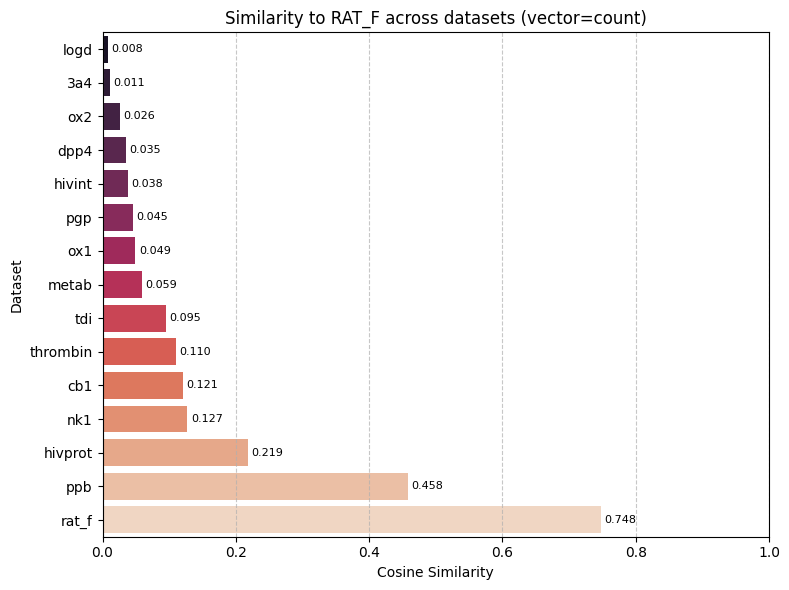

In [71]:
dataset_name = "rat_f"
ranked = rank_similarity_scores(cos_sim_df_count_data, dataset_name)
visualize_ranked_similarity(ranked, dataset_name)

/tmp/ipykernel_1159707/2124652443.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Similarity', y='Dataset', data=df, palette='rocket')


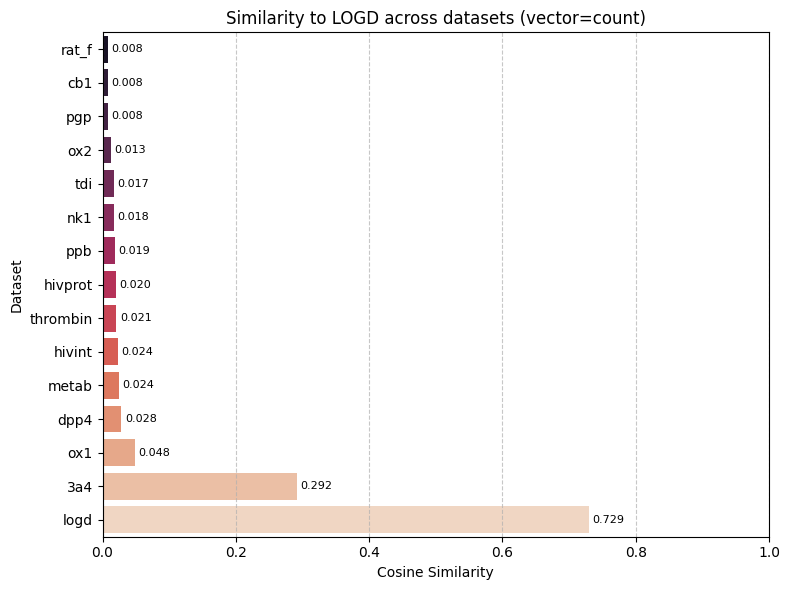

In [66]:
dataset_name = "logd"
ranked = rank_similarity_scores(cos_sim_df_count_data, dataset_name)
visualize_ranked_similarity(ranked, dataset_name)

In [58]:
# 3a4, logd -> Ïûë (0.027268 Ïù¥ÌïòÎ°ú cut)
ranked_3a4 = rank_similarity_scores(cos_sim_df_count_data, "hivprot")
print(ranked_3a4)

hivprot     0.858072
rat_f       0.218584
ppb         0.145659
thrombin    0.097697
nk1         0.064963
cb1         0.054434
ox2         0.052660
metab       0.051260
hivint      0.050245
ox1         0.049442
pgp         0.041119
tdi         0.039413
dpp4        0.027268
3a4         0.025439
logd        0.020113
Name: hivprot, dtype: float64


/tmp/ipykernel_1159707/2124652443.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Similarity', y='Dataset', data=df, palette='rocket')


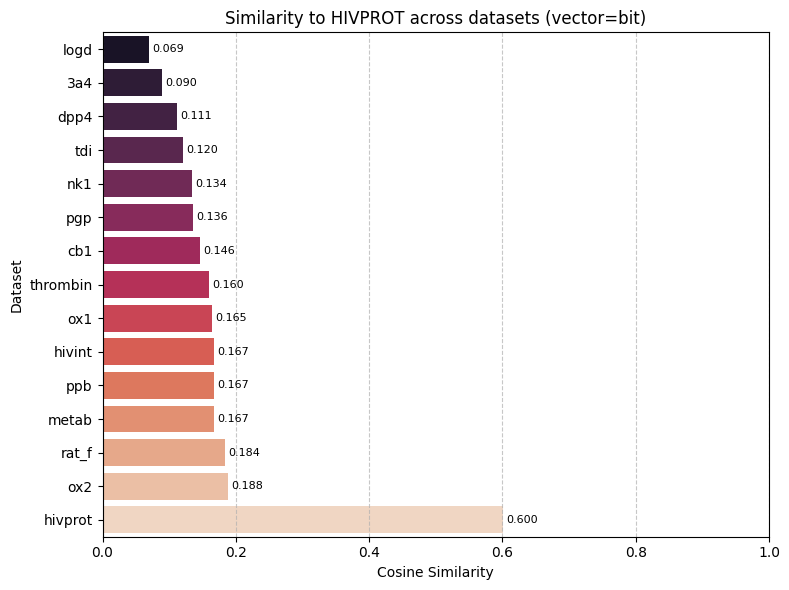

In [62]:
# 3a4, logd -> Ïûë (0.027268 Ïù¥ÌïòÎ°ú cut)
dataset_name = "hivprot"
ranked = rank_similarity_scores(cos_sim_df_bit_data, dataset_name)
visualize_ranked_similarity(ranked, dataset_name, vec="bit")

/tmp/ipykernel_1159707/2124652443.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Similarity', y='Dataset', data=df, palette='rocket')


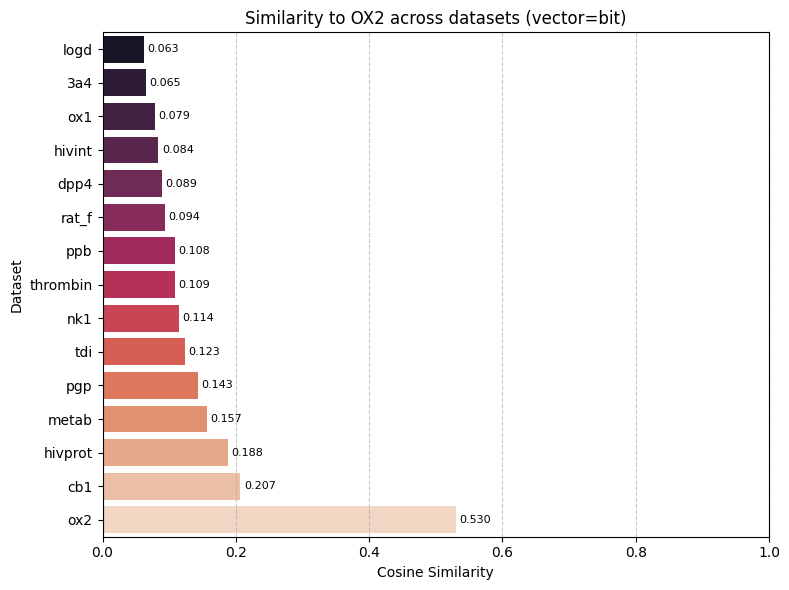

In [72]:
dataset_name = "ox2"
ranked = rank_similarity_scores(cos_sim_df_bit_data, dataset_name)
visualize_ranked_similarity(ranked, dataset_name, vec="bit")

/tmp/ipykernel_1159707/2124652443.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Similarity', y='Dataset', data=df, palette='rocket')


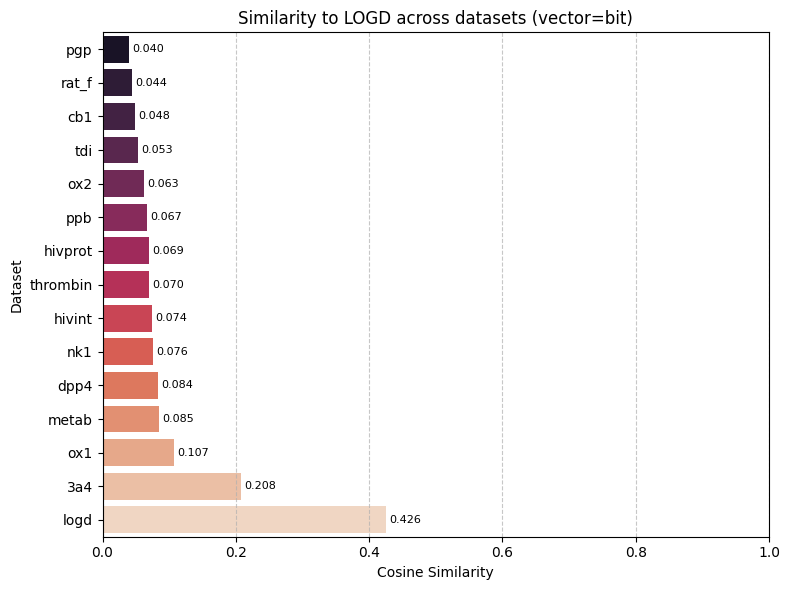

In [67]:
dataset_name = "logd"
ranked = rank_similarity_scores(cos_sim_df_bit_data, dataset_name)
visualize_ranked_similarity(ranked, dataset_name, vec="bit")

In [24]:
## hivprot COUNT Í∏∞Ï§Ä
# metab, ox2, logd, pgp, cb1 ÏÇ¨Ïã§ Îã§ Ï¢ãÏùå
# Î≤ÑÎ†§Ïïº Ìï† Í≤É : hivint, (rat_f, ox1) ÎÇòÎ®∏ÏßÄ good

ranked_3a4 = rank_similarity_scores(cos_sim_df_count_data, "3a4")
print(ranked_3a4)

3a4         0.741623
logd        0.291844
dpp4        0.037596
hivint      0.030762
metab       0.029329
ox1         0.028205
thrombin    0.025448
hivprot     0.025439
ox2         0.022344
ppb         0.017234
nk1         0.017207
cb1         0.016559
tdi         0.015064
pgp         0.011680
rat_f       0.011089
Name: 3a4, dtype: float64


In [25]:
## hivprot COUNT Í∏∞Ï§Ä
# hivitnt : 0.389637
# 3a4, metab, hivint, tdi, ox1 -> logdÏôÄ sim ÌÅ∞ (top4: 0.020887 Ï¥àÍ≥º)
# Î≤ÑÎ†§Ïïº Ìï† Í≤É : thormbin, ppb, rat_f, ox2, cb1, pgp
ranked_3a4 = rank_similarity_scores(cos_sim_df_count_data, "logd")
print(print(ranked_3a4))

logd        0.729356
3a4         0.291844
ox1         0.048310
dpp4        0.028350
metab       0.024234
hivint      0.023801
thrombin    0.020887
hivprot     0.020113
ppb         0.019249
nk1         0.017577
tdi         0.016639
ox2         0.012811
pgp         0.008142
cb1         0.007759
rat_f       0.007610
Name: logd, dtype: float64
None


### dpp4 count

/tmp/ipykernel_1159707/2124652443.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Similarity', y='Dataset', data=df, palette='rocket')


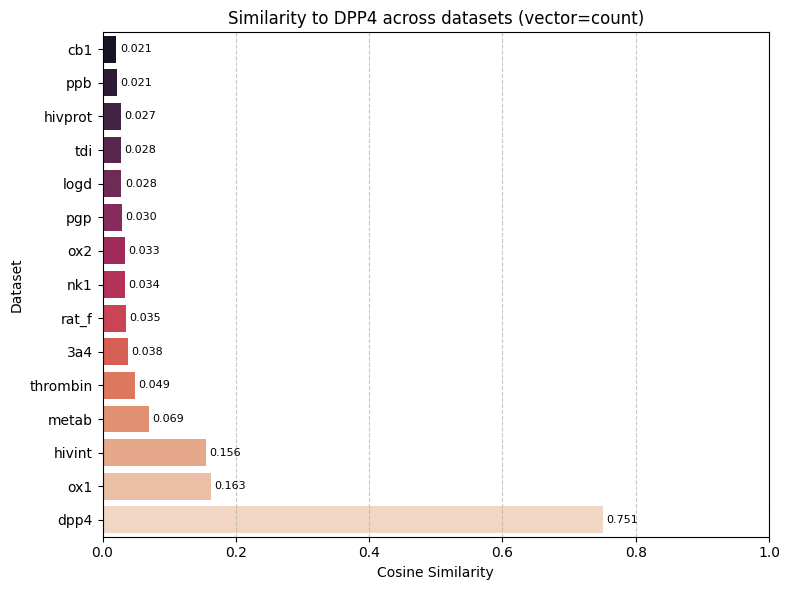

In [63]:
dataset_name = "dpp4"
ranked = rank_similarity_scores(cos_sim_df_count_data, dataset_name)
visualize_ranked_similarity(ranked, dataset_name, vec="count")

/tmp/ipykernel_1159707/2124652443.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Similarity', y='Dataset', data=df, palette='rocket')


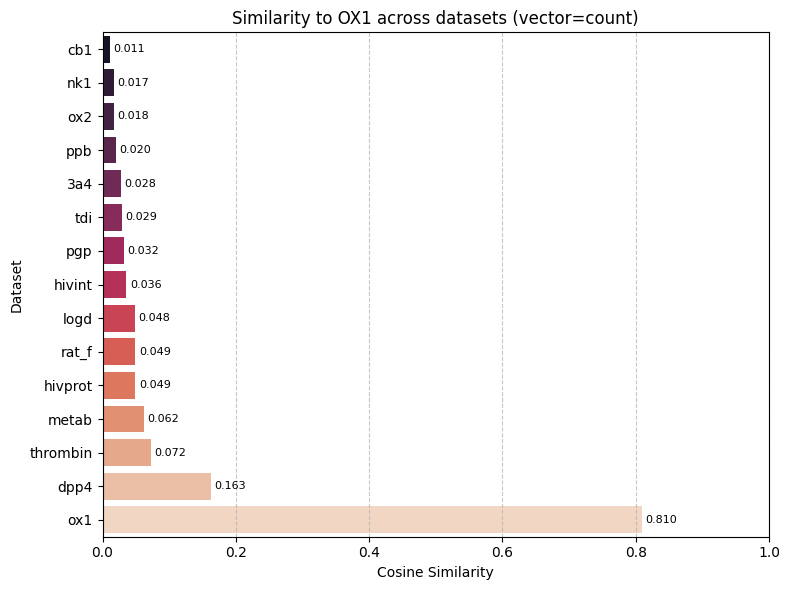

In [73]:
dataset_name = "ox1"
ranked = rank_similarity_scores(cos_sim_df_count_data, dataset_name)
visualize_ranked_similarity(ranked, dataset_name, vec="count")

/tmp/ipykernel_1159707/2124652443.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Similarity', y='Dataset', data=df, palette='rocket')


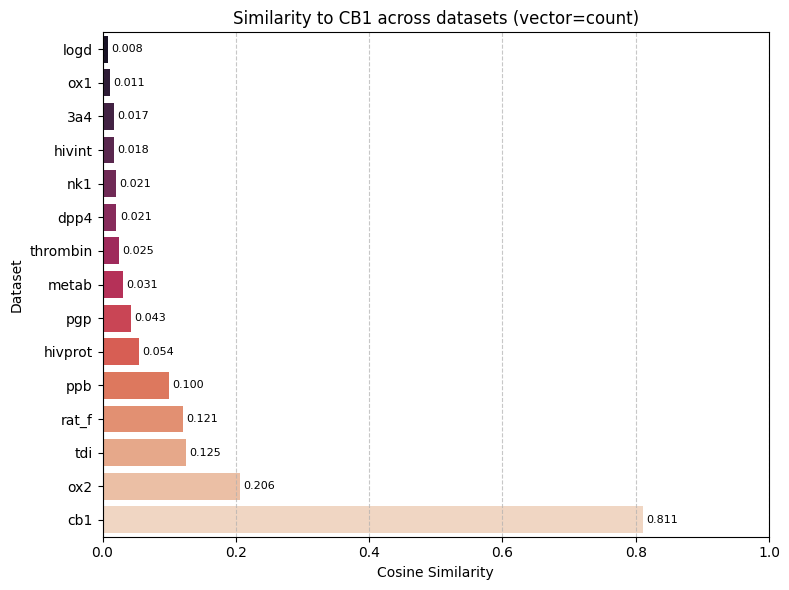

In [68]:
dataset_name = "cb1"
ranked = rank_similarity_scores(cos_sim_df_count_data, dataset_name)
visualize_ranked_similarity(ranked, dataset_name, vec="count")

/tmp/ipykernel_1159707/2124652443.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Similarity', y='Dataset', data=df, palette='rocket')


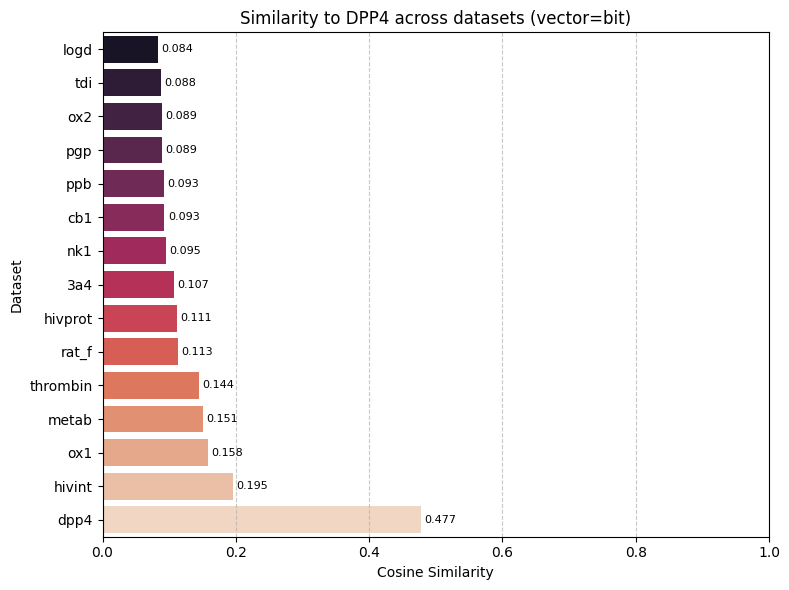

In [64]:
dataset_name = "dpp4"
ranked = rank_similarity_scores(cos_sim_df_bit_data, dataset_name)
visualize_ranked_similarity(ranked, dataset_name, vec="bit")

/tmp/ipykernel_1159707/2124652443.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Similarity', y='Dataset', data=df, palette='rocket')


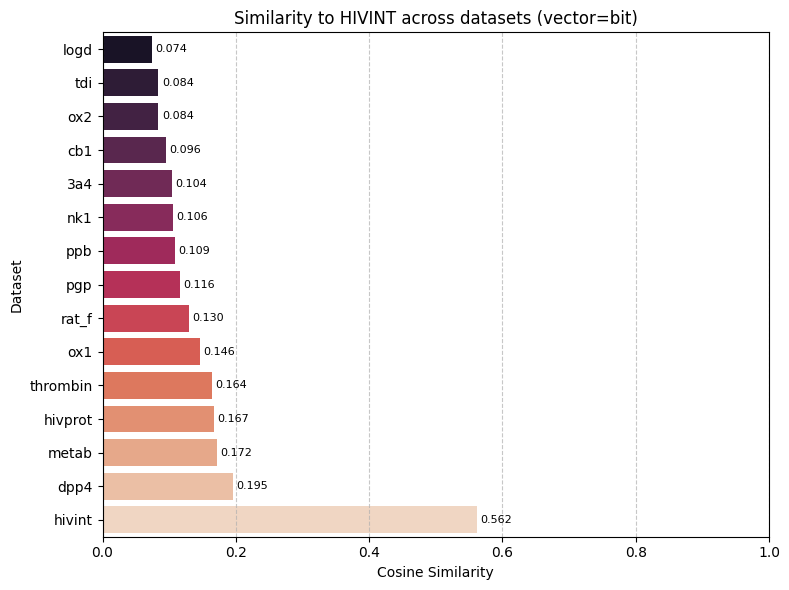

In [74]:
dataset_name = "hivint"
ranked = rank_similarity_scores(cos_sim_df_bit_data, dataset_name)
visualize_ranked_similarity(ranked, dataset_name, vec="bit")

/tmp/ipykernel_1159707/2124652443.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Similarity', y='Dataset', data=df, palette='rocket')


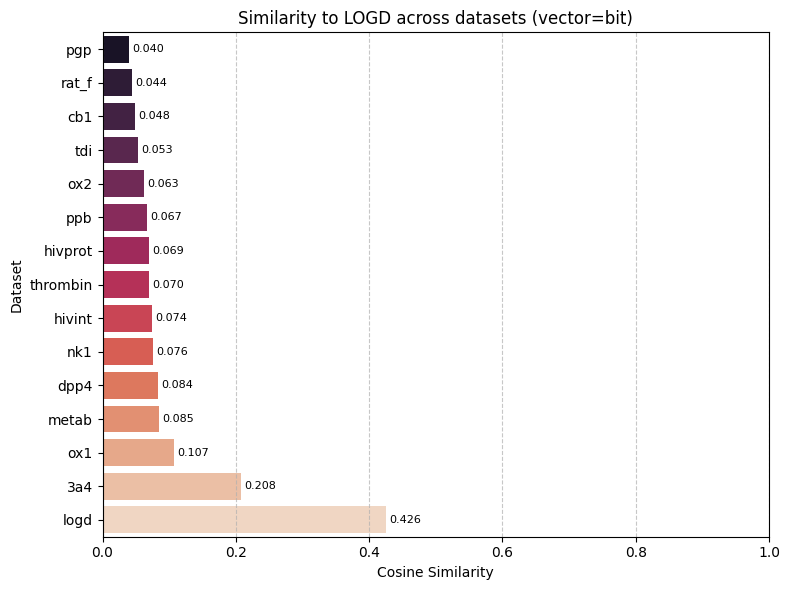

In [69]:
dataset_name = "logd"
ranked = rank_similarity_scores(cos_sim_df_bit_data, dataset_name)
visualize_ranked_similarity(ranked, dataset_name, vec="bit")

/tmp/ipykernel_1159707/2124652443.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Similarity', y='Dataset', data=df, palette='rocket')


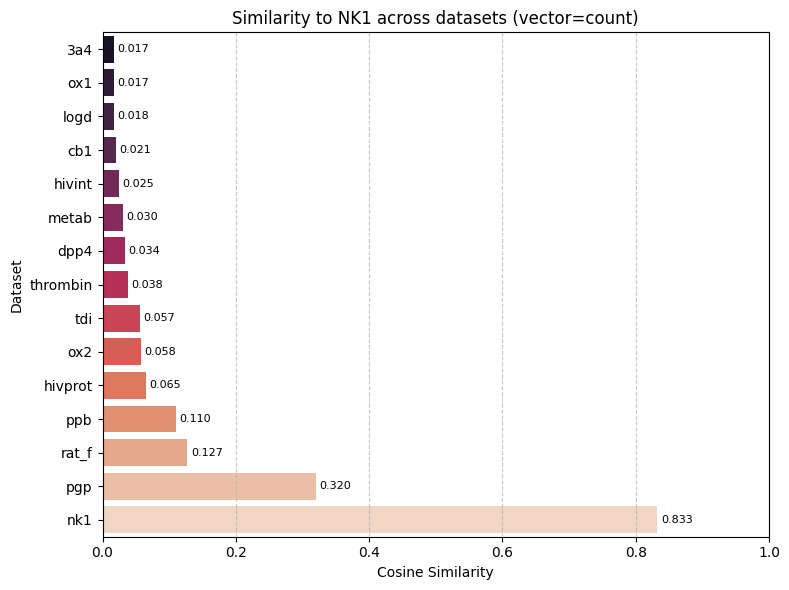

/tmp/ipykernel_1159707/2124652443.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Similarity', y='Dataset', data=df, palette='rocket')


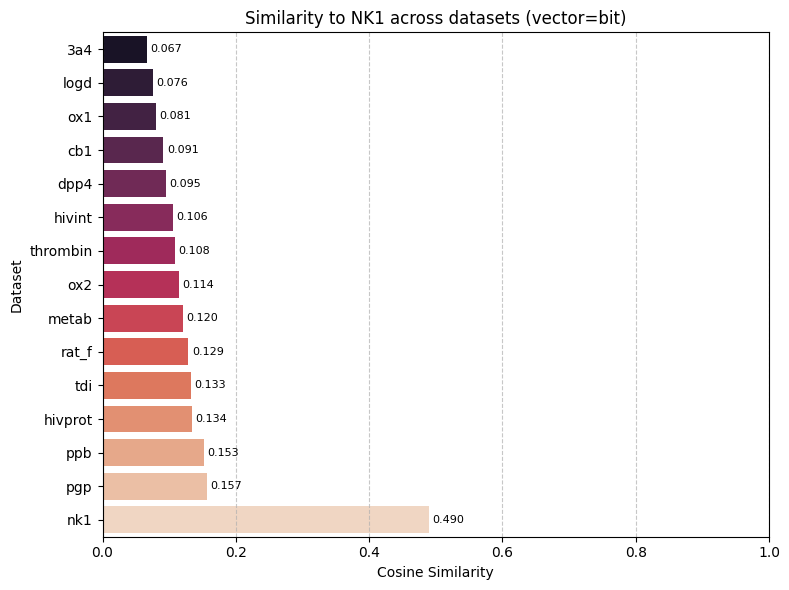

In [65]:
dataset_name = "nk1"

ranked = rank_similarity_scores(cos_sim_df_count_data, dataset_name)
visualize_ranked_similarity(ranked, dataset_name, vec="count")

ranked = rank_similarity_scores(cos_sim_df_bit_data, dataset_name)
visualize_ranked_similarity(ranked, dataset_name, vec="bit")

/tmp/ipykernel_1159707/2124652443.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Similarity', y='Dataset', data=df, palette='rocket')


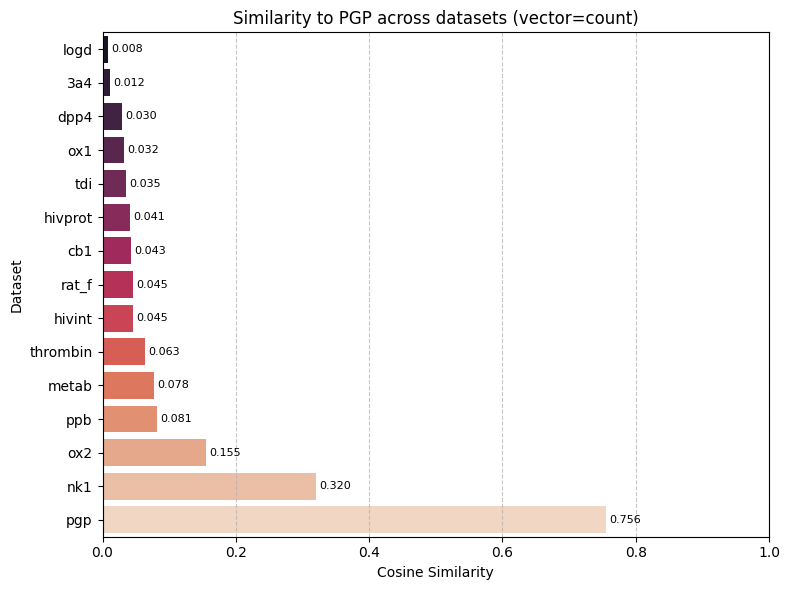

In [75]:
dataset_name = "pgp"

ranked = rank_similarity_scores(cos_sim_df_count_data, dataset_name)
visualize_ranked_similarity(ranked, dataset_name, vec="count")

/tmp/ipykernel_1159707/2124652443.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Similarity', y='Dataset', data=df, palette='rocket')


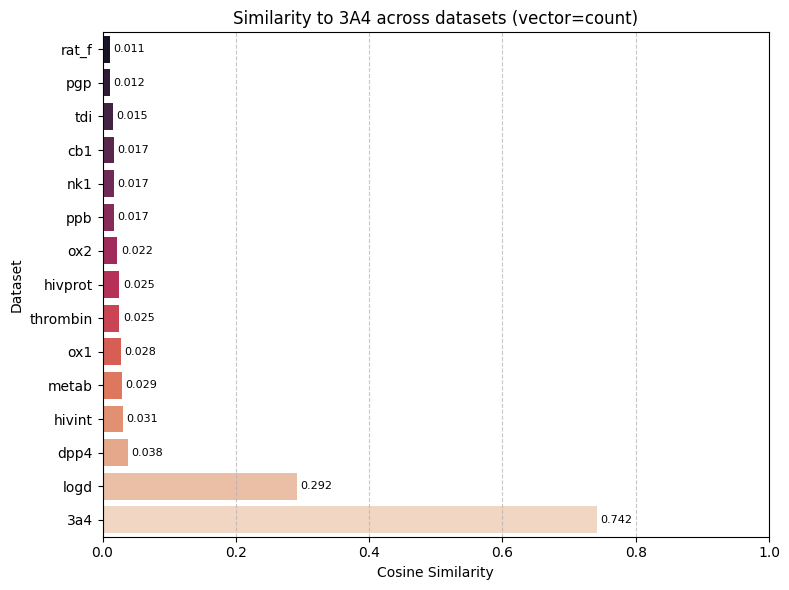

In [70]:
dataset_name = "3a4"

ranked = rank_similarity_scores(cos_sim_df_count_data, dataset_name)
visualize_ranked_similarity(ranked, dataset_name, vec="count")

In [26]:
# Ï£ºÎ°ú Ïûë cb1, logd, tdi, ppb, thrombin (ÏòàÏô∏ : thrombin) ~ lowest 4 (pgp include Ïó¨Î∂Ä Í≤∞Ï†ïÌï¥Ïïº )
# TODO dpp4Ïùò Í≤ΩÏö∞ thrombin Ïù¥ Ïôú Ï¢ãÏùÄÏßÄÏóê ÎåÄÌïú Ïù¥Ïú†Í∞Ä ÏûàÎã§Î©¥ Ï¢ãÏùÑÎìØ
# 3a4Îäî Ï¢ãÏßÄ ÏïäÏúºÎÇò ppbÎèÑ Î≥ÑÎ°ú
# thrombin, logd, cb1
ranked_3a4 = rank_similarity_scores(cos_sim_df_count_data, "dpp4")
print(print(ranked_3a4))

dpp4        0.750980
ox1         0.162877
hivint      0.155505
metab       0.069325
thrombin    0.048603
3a4         0.037596
rat_f       0.034814
nk1         0.034206
ox2         0.033404
pgp         0.029739
logd        0.028350
tdi         0.027543
hivprot     0.027268
ppb         0.021069
cb1         0.020872
Name: dpp4, dtype: float64
None


In [37]:
ranked_3a4 = rank_similarity_scores(cos_sim_df_bit_data, "dpp4")
print(print(ranked_3a4))

dpp4        0.477463
hivint      0.195279
ox1         0.158239
metab       0.151057
thrombin    0.144050
rat_f       0.113172
hivprot     0.111425
3a4         0.107440
nk1         0.094580
cb1         0.092865
ppb         0.092613
pgp         0.089284
ox2         0.088657
tdi         0.088033
logd        0.083856
Name: dpp4, dtype: float64
None


In [28]:
# Î≤ÑÎ†§Ïïº Ìï† Í≤É : ox1 Ï†úÏô∏Ìï¥Ïïº, (3a4, rat_f soso)
# Ï¢ãÏùÄ value : logd, thrombin, tdi, //  hivint, ppb, pgp
# logd, thromb, hivintÍ∞Ä Ï¢ãÍ∏¥ ÌïúÎç∞ (top7: 0.020887 Ï¥àÍ≥º) - 1.064066ÍπåÏßÄ

ranked_3a4 = rank_similarity_scores(cos_sim_df_count_data, "cb1")
print(print(ranked_3a4))

cb1         0.811129
ox2         0.206292
tdi         0.125184
rat_f       0.121138
ppb         0.099535
hivprot     0.054434
pgp         0.043201
metab       0.031269
thrombin    0.024999
dpp4        0.020872
nk1         0.020685
hivint      0.017681
3a4         0.016559
ox1         0.010840
logd        0.007759
Name: cb1, dtype: float64
None


In [29]:
# rat_f Ïïà Ï¢ãÍ∏¥ ÌïúÎç∞ (top8: 0.023 Ïù¥ÏÉÅ)
# Î≤ÑÎ†§Ïïº Ìï† Í≤É : rat_f, ox1, 
# Ï¢ãÏùÄ value : 
ranked_3a4 = rank_similarity_scores(cos_sim_df_count_data, "ppb")
print(print(ranked_3a4))

ppb         0.763072
rat_f       0.457898
hivprot     0.145659
tdi         0.116054
nk1         0.109770
cb1         0.099535
pgp         0.081175
thrombin    0.065137
ox2         0.041573
metab       0.033024
hivint      0.026836
dpp4        0.021069
ox1         0.020132
logd        0.019249
3a4         0.017234
Name: ppb, dtype: float64
None


In [30]:
# 0.020887 Ï¥àÍ≥ºÏãú ox1 ~ Î≤ÑÎ†§Ïïº Ìï† Í±∞ ÎßéÏù¥ include ÌïòÍ∏¥ Ìï® 
# Î≤ÑÎ†§Ïïº Ìï† Í≤É : hivint, rat_f, ox2, ox1

ranked_3a4 = rank_similarity_scores(cos_sim_df_count_data, "tdi")
print(print(ranked_3a4))

tdi         0.760228
cb1         0.125184
ppb         0.116054
rat_f       0.094789
nk1         0.056553
ox2         0.053046
thrombin    0.046999
hivprot     0.039413
pgp         0.035484
ox1         0.028596
dpp4        0.027543
metab       0.021020
hivint      0.017748
logd        0.016639
3a4         0.015064
Name: tdi, dtype: float64
None


In [31]:
# 0.020887 Ï¥àÍ≥ºÏãú 
# Ïù¥Í±¥ sim ÏûëÏùÄ ÏñòÎì§Ïù¥ Ï¢ãÍ∏¥ Ìï®, Î≤ÑÎ†§Ïïº Ìï† Í≤É : 3a4 (critical ÏùÄ ÏïÑÎãò)

ranked_3a4 = rank_similarity_scores(cos_sim_df_count_data, "logd")
print(print(ranked_3a4))

logd        0.729356
3a4         0.291844
ox1         0.048310
dpp4        0.028350
metab       0.024234
hivint      0.023801
thrombin    0.020887
hivprot     0.020113
ppb         0.019249
nk1         0.017577
tdi         0.016639
ox2         0.012811
pgp         0.008142
cb1         0.007759
rat_f       0.007610
Name: logd, dtype: float64
None


In [32]:
ranked_3a4 = rank_similarity_scores(cos_sim_df_count_data, "nk1")
print(print(ranked_3a4))

nk1         0.832585
pgp         0.319777
rat_f       0.127448
ppb         0.109770
hivprot     0.064963
ox2         0.058073
tdi         0.056553
thrombin    0.037864
dpp4        0.034206
metab       0.030303
hivint      0.024532
cb1         0.020685
logd        0.017577
ox1         0.017416
3a4         0.017207
Name: nk1, dtype: float64
None


In [ ]:
ranked_3a4 = rank_similarity_scores(cos_sim_df_bit_data, "nk1")
print(print(ranked_3a4))

### Bit

In [33]:
# 3a4, logd -> Ïûë (0.027268 Ïù¥ÌïòÎ°ú cut)
ranked_3a4 = rank_similarity_scores(cos_sim_df_bit_data, "hivprot")
print(ranked_3a4)

hivprot     0.600308
ox2         0.187723
rat_f       0.183581
metab       0.167222
ppb         0.167135
hivint      0.167052
ox1         0.164688
thrombin    0.160012
cb1         0.145979
pgp         0.136282
nk1         0.133762
tdi         0.120161
dpp4        0.111425
3a4         0.089517
logd        0.069258
Name: hivprot, dtype: float64


In [34]:
# 3a4, logd -> Ïûë (0.027268 Ïù¥ÌïòÎ°ú cut)
ranked_3a4 = rank_similarity_scores(cos_sim_df_bit_data, "dpp4")
print(ranked_3a4)

dpp4        0.477463
hivint      0.195279
ox1         0.158239
metab       0.151057
thrombin    0.144050
rat_f       0.113172
hivprot     0.111425
3a4         0.107440
nk1         0.094580
cb1         0.092865
ppb         0.092613
pgp         0.089284
ox2         0.088657
tdi         0.088033
logd        0.083856
Name: dpp4, dtype: float64


In [38]:
# 3a4, logd -> Ïûë (0.027268 Ïù¥ÌïòÎ°ú cut)
ranked_3a4 = rank_similarity_scores(cos_sim_df_count_data, "nk1")
print(ranked_3a4)

nk1         0.832585
pgp         0.319777
rat_f       0.127448
ppb         0.109770
hivprot     0.064963
ox2         0.058073
tdi         0.056553
thrombin    0.037864
dpp4        0.034206
metab       0.030303
hivint      0.024532
cb1         0.020685
logd        0.017577
ox1         0.017416
3a4         0.017207
Name: nk1, dtype: float64


In [35]:
# 3a4, logd -> Ïûë (0.027268 Ïù¥ÌïòÎ°ú cut)
ranked_3a4 = rank_similarity_scores(cos_sim_df_bit_data, "nk1")
print(ranked_3a4)

nk1         0.489624
pgp         0.157372
ppb         0.152641
hivprot     0.133762
tdi         0.132944
rat_f       0.128966
metab       0.120243
ox2         0.114281
thrombin    0.108457
hivint      0.105880
dpp4        0.094580
cb1         0.091431
ox1         0.080562
logd        0.076355
3a4         0.066663
Name: nk1, dtype: float64


## Exclude

### Count

hiv

### Bit

### Set Transformer